# BIA Seminar 6
## Image reconstruction baseline

Throughout this tutorial we assume that the images have been rigidly aligned in a (roughly) similar space.  
Rigid alignment is also possible with VoxelMorph, but it's not our focus here.  A separate tutorial is being designed for that


### References
[VoxelMorph at TMI](https://arxiv.org/abs/1809.05231)   
[Diffeomorphic VoxelMorph at MedIA](https://arxiv.org/abs/1903.03545)   
[Neurite Library](https://github.com/adalca/neuron) - [CVPR](http://arxiv.org/abs/1903.03148)

---

# Preamble
## Setup of environment

In [1]:
import os
# Set this up if and only if you:
# - Have multiple GPUs
# - Want to use a particular one
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [1]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph 

Looking in indexes: https://pypi.yandex-team.ru/simple/


We'll start with some common imports  

In [2]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

Next, we import two packages that will help us   
- [voxelmorph](http://voxelmorph.mit.edu) is a deep-learning based registration library  
- [neurite](https://github.com/adalca/neurite) is a library for medical image analysis with tensorflow  

In [3]:
# local imports
import voxelmorph as vxm
import neurite as ne

---

# Data

To be able to train and easily register during this tutorial, we will first extract the middle slice of brain scans.

Note that because this task does not capture deformations in the third dimensions, certain  correspondances are not exactly possible.  Nonetheless, this exercise will illustrate registration with realistic complex images.   

The brains have been intensity-normalized affinely aligned, and skull-stripped with FreeSurfer, to enable focusing on deformable registration.

In [4]:
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

--2023-05-18 16:08:12--  https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 64:ff9b::84b7:12b
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|64:ff9b::84b7:12b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16644702 (16M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  15.87M  9.82MB/s    in 1.6s    

2023-05-18 16:08:15 (9.82 MB/s) - ‘data.tar.gz’ saved [16644702/16644702]

brain_2d_no_smooth.h5
brain_2d_smooth.h5
brain_3d.h5
fs_rgb.npy
subj1.npz
subj2.npz
tutorial_data.npz


In [7]:
npz = np.load('tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

# the 208 volumes are of size 160x192
vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

train shape: (208, 192, 160)


Let's take a look at some of the data.  
Here, we use some tools from a package called neurite, which uses matplotlib.  
You could use matplotlib as well directly, but it would just be a bit messier.  
and here we want to illustrate the main concepts.

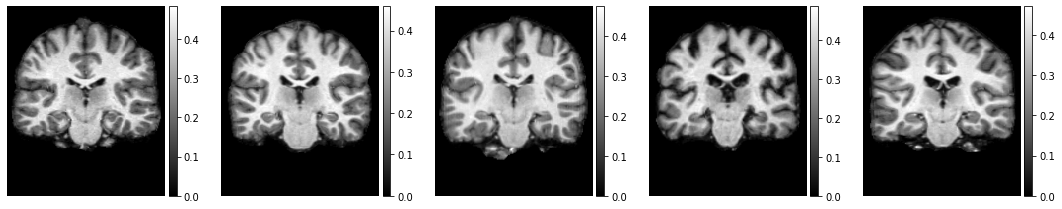

In [8]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

Looks good!  

However, luckily we included a **colorbar**, which shows us that the data is in [0, 1].  
In neural networks it's often great to work in the ranges of [0, 1] or [-1, 1] or around there.  
We do not need to do any normalization here but you should keep in mind that if you have data in [0, 255] range you better normalize it first. 

In general, you should always plot your data with colorbars, which helps you catch issues before training  

# CNN Model

Given two images (which we call *moving* and *fixed*), our goal is to find the deformation between them. In learning-based methods, we use a network that takes in two images $m$ ("moving") and $f$ ("fixed") and outputs a dense deformation $\phi$ (e.g. size $(h, w, 2)$, because at each pixel we want a vector telling us where to go). Intuitively, this deformation $\phi$ gives us the correspondances between the images, and tells us how to moving the moving image to match up with the fixed image. 

**Note**: Registration also includes (or refers to) affine transforms, but we ignore that here.

The [VoxelMorph](http://voxelmorph.mit.edu) library provides a `VxmDense` model class for building dense deformation networks. We will discuss this class later on, but for tutorial sake, we'll start by building this model from scratch in order to demonstrate the individual components of the network. First, we're going to abstract the UNet and with the `vxm.networks.Unet()` model.

In [9]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*x_train.shape[1:], unet_input_features)

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)

Let's explore the model bit...

In [10]:
print('input shape: ', unet.input.shape)
print('output shape:', unet.output.shape)

input shape:  (None, 192, 160, 2)
output shape: (None, 192, 160, 16)


Now we need to make sure the final output has 2 features, representing the deformation at each voxel.

In [11]:
# transform the results into a flow field.
disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

# check tensor shape
print('displacement tensor:', disp_tensor.shape)

# using keras, we can easily form new models via tensor pointers
def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

displacement tensor: (None, 192, 160, 2)


The deformation model `def_model` will now *share layers* with the UNet model, so if we change layer weights in `unet`, they change in `def_model`.

### Loss

Given that the displacement $\phi$ is output from the network,  
we need to figure out a loss to tell if it makes sense

In a **supervised setting** we would have ground truth deformations $\phi_{gt}$,  
and we could use a supervised loss like MSE $= \| \phi - \phi_{gt} \|$

The main idea in **unsupervised registration** is to use loss inspired by classical registration  

Without supervision, how do we know this deformation is good?  
(1) make sure that $m \circ \phi$ ($m$ warped by $\phi$) is close to $f$  
(2) regularize $\phi$ (often meaning make sure it's smooth)  

To achieve (1), we need to *warp* input image $m$. To do this, we use a spatial transformation network layer, which essentially does linear interpolation.

In [12]:
# build transformer layer
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')

# extract the first frame (i.e. the "moving" image) from unet input tensor
moving_image = tf.expand_dims(unet.input[..., 0], axis=-1)

# warp the moving image with the transformer
moved_image_tensor = spatial_transformer([moving_image, disp_tensor])

To make sure the moved image is close to the fixed image, and to achieve smoothness loss of $\phi$ in (2), we will want these two as outputs from the full model.

In [13]:
outputs = [moved_image_tensor, disp_tensor]
vxm_model = tf.keras.models.Model(inputs=unet.inputs, outputs=outputs)

The model we just created represents the standard, dense VoxelMorph archetecture, with a UNet component, displacement field, and final spatial transformer layer. However, you don't have to build this model from scratch every time - the VoxelMorph library provides a highly customizable `VxmDense` model class that encompasses this archetecture.

From now on in the tutorial, we will be using `VxmDense` class to build models, so let's rebuild the equivolent network.

In [14]:
# build model using VxmDense
inshape = x_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

The `int_steps=0` option disables diffeomorphism, which will be covered in a more advanced tutorial.

It's worth noting that the `VxmDense` model is automatically configured with two input tensors (moving and fixed inputs) instead of one. The input shape parameter should not contain any feature information, which can be set via the optional `src_feats` and `trg_feats` parameters.

Let's take one final look at the model.

In [15]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 192, 160, 1), (None, 192, 160, 1)
output shape: (None, 192, 160, 1), (None, 192, 160, 2)


Now that've learned how to easily build our networks, let's define the actual loss. The way keras works, we need to define a loss for each output.    
The first loss is easy, it's simply MSE between the warped image $m \circ \phi$.
For the second, we will use a spatial gradient of the displacement.  
We won't code this from scratch here, but we'll use the `voxelmorph` implementation.

In [16]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

Finally, we can compile the model. 
This sets up the model for training, by associating the model with a loss and an optimizer

In [17]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# Train Model

To train, we need to make sure the data is in the right format and fed to the model the way we want it keras models can be trained with `model.fit`, which requires all the data to be in a big array, or `model.fit_generator`, which requires a python generator that gives you batches of data.

Let's code a simple data generator.

In [18]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

It's always a good idea to visualize the loss, not just read off the numbers. This will give us a better idea of whether it's converged, etc. Tensorflow offers a powerful interactive system for visualizing called tensorboard. For this short tutorial, we will simply plot the loss.

### Model

In [19]:
# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]

From experimentation, we have found the Adam optimizer learning rate of `1e-4` performs better than `1e-3` for this problem.

In [20]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

Luckily, we can use the same generator as before, since we're using the same format. Let's test it first.

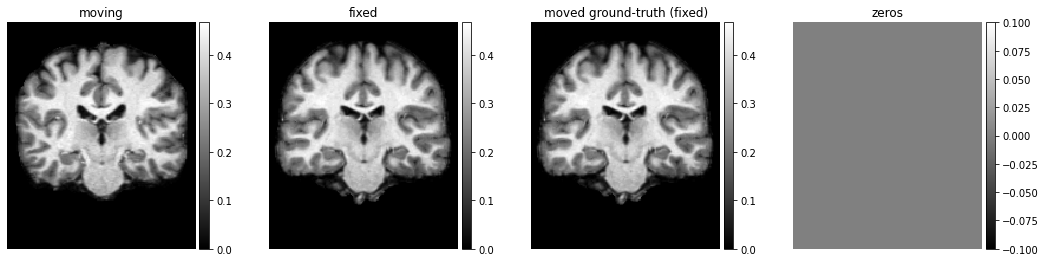

In [21]:
# let's test it
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Looks good, time to **train the model**

In [22]:
hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);

<ipython-input-22-2a3595386513>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);


Epoch 1/5
5/5 - 11s - loss: 0.0075 - vxm_dense_transformer_loss: 0.0075 - vxm_dense_flow_loss: 1.1406e-05 - 11s/epoch - 2s/step
Epoch 2/5
5/5 - 0s - loss: 0.0069 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 1.4574e-04 - 150ms/epoch - 30ms/step
Epoch 3/5
5/5 - 0s - loss: 0.0064 - vxm_dense_transformer_loss: 0.0064 - vxm_dense_flow_loss: 5.9113e-05 - 145ms/epoch - 29ms/step
Epoch 4/5
5/5 - 0s - loss: 0.0065 - vxm_dense_transformer_loss: 0.0065 - vxm_dense_flow_loss: 2.3318e-04 - 144ms/epoch - 29ms/step
Epoch 5/5
5/5 - 0s - loss: 0.0064 - vxm_dense_transformer_loss: 0.0064 - vxm_dense_flow_loss: 7.9862e-04 - 140ms/epoch - 28ms/step


It's always a good idea to visualize the loss, not just read off the numbers. This will give us a better idea of whether it's converged, etc. Tensorflow offers a powerful interactive system for visualizing called tensorboard. For this short tutorial, we will simply plot the loss.

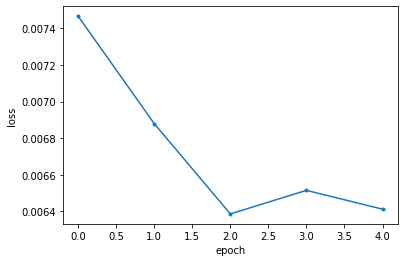

In [24]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    
plot_history(hist)

We ran very few epochs for the purpose of the tutorial. Of course, we do not except any sort of reasonable convergence here. Let's load a model pretrained for 200 epochs:

In [25]:
# load pretrained model weights
vxm_model.load_weights('brain_2d_smooth.h5')

Now let's see some results using validation data...

In [26]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

In [27]:
# prediction
val_pred = vxm_model.predict(val_input)

1/1 [==============================] - 1s 533ms/step


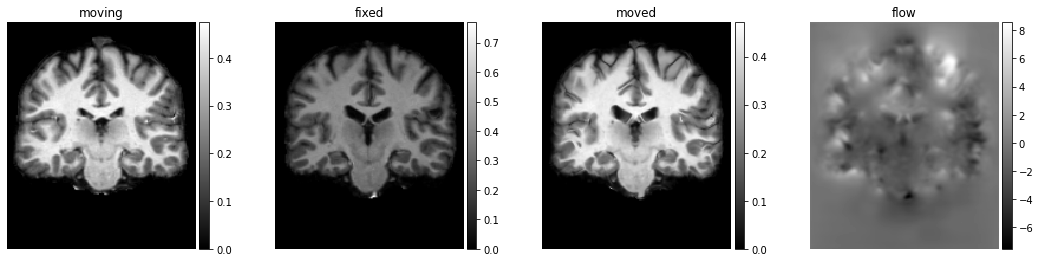

In [28]:
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

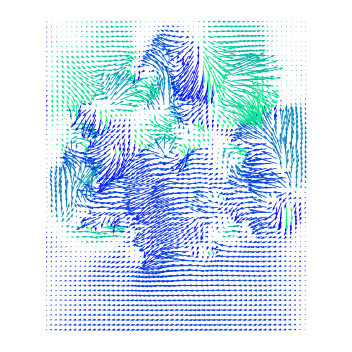

In [29]:
# visualize flow
flow = val_pred[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

# Evaluation

Evaluating registration results is tricky. The first tendancy is to look at the images (as above), and conclude that if they match, The registration has succeeded.

However, this can be achieved by an optimization that only penalizes the image matching term. For example, next we compare our model with one that was trained on maximizing MSE only (without smoothness loss).

In [30]:
# prediction from model with MSE + smoothness loss
vxm_model.load_weights('brain_2d_smooth.h5')
our_val_pred = vxm_model.predict(val_input)

# prediction from model with just MSE loss
vxm_model.load_weights('brain_2d_no_smooth.h5')
mse_val_pred = vxm_model.predict(val_input)

1/1 [==============================] - 0s 44ms/step


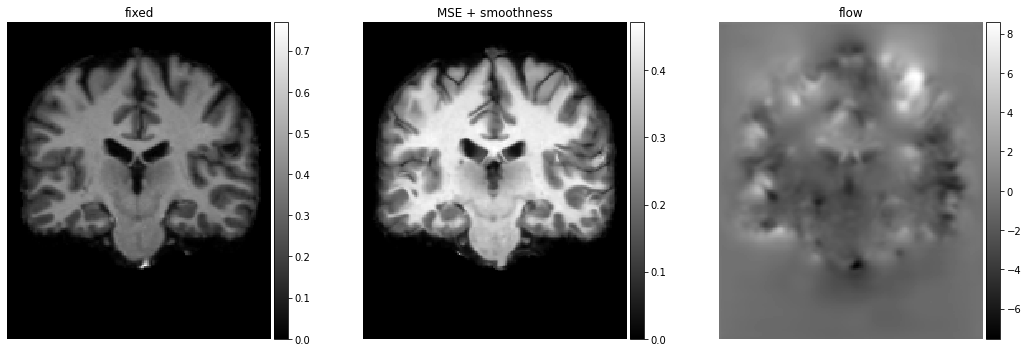

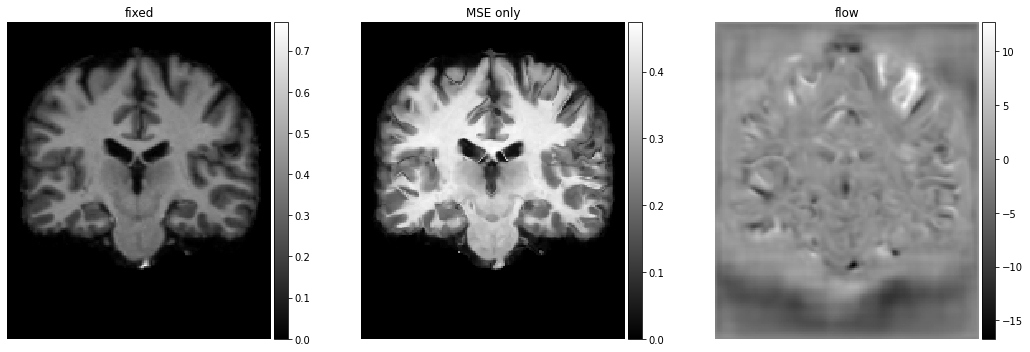

In [31]:
# visualize MSE + smoothness model output
images = [img[0, ..., 0] for img in [val_input[1], *our_val_pred]]
titles = ['fixed', 'MSE + smoothness', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# visualize MSE model output
images = [img[0, ..., 0] for img in [val_input[1], *mse_val_pred]]
titles = ['fixed', 'MSE only', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

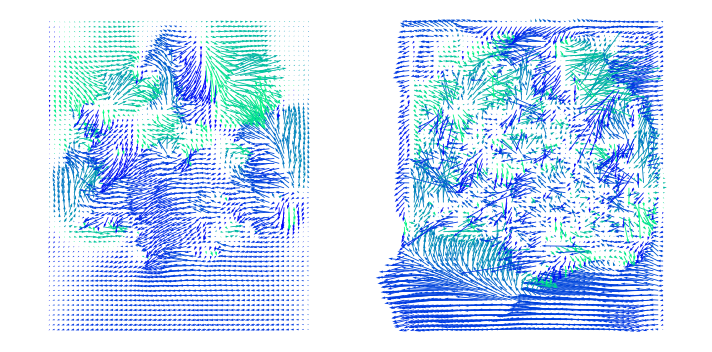

In [32]:
ne.plot.flow([img[1].squeeze()[::3, ::3] for img in [our_val_pred, mse_val_pred]], width=10);

At first look, the MSE-only model matches the fixed image better, but we can see that it obtains a deformation field that is very noisy, unlikely to be anatomically meaningful.

What we often do isntead of use **external anotations** for evaluation one way is using anatomical segmentations.  

In the next section, we demonstrate the use of a 3D model, and show how to evaluate it with segmentations.